In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j
    return arr.flatten()

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [3]:
arr = to_one_hot([0, 2, 4])
arr

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [4]:
from_one_hot(arr)

array([0., 2., 4.])

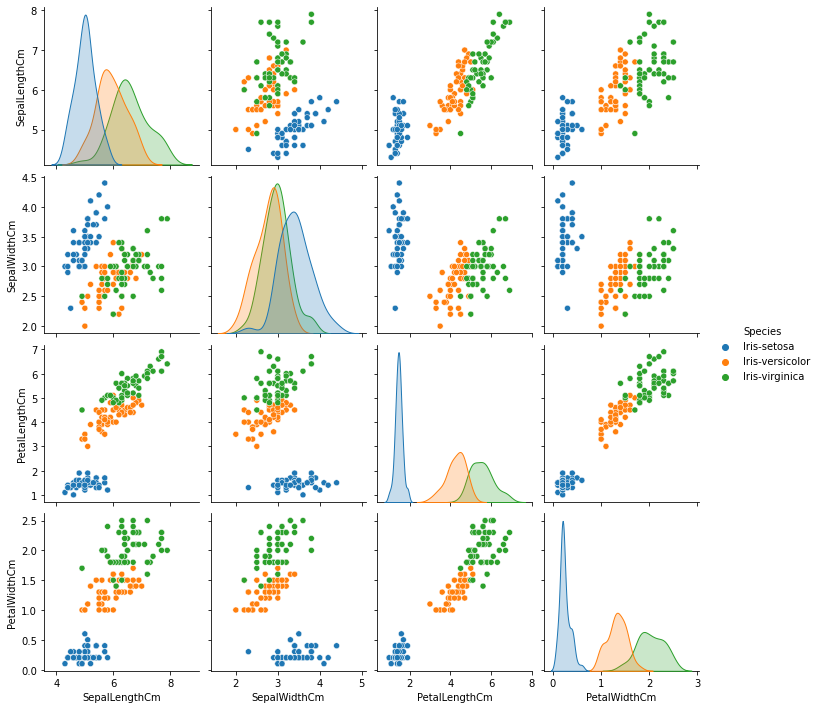

In [5]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [6]:
np.random.seed(1)

### 1 слой

In [7]:
def train_nn_l1(data, target, n_numb, iters):
    # определим число нейронов скрытого слоя
    neuron_numb = n_numb
    
    # присваивание случайных весов
    w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, 3 выхода
    w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода # откуда 5 входов?

    # скорость обучения (learning rate)
    n = 0.1

    # массив для ошибок, чтобы потом построить график
    errors = []

    # процесс обучения
    for i in range(iters):

        # прямое распространение(feed forward)
        layer0 = data # (100, 4) для neuron_numb = 2
        layer1 = sigmoid(np.dot(layer0, w0)) # (100, 4) x (4, 2) -> (100, 2)
        layer2 = sigmoid(np.dot(layer1, w1)) # (100, 2) x (2, 3) -> (100, 3)

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = target - layer2 # производная функции потерь = производная квадратичных потерь 
        layer2_delta = layer2_error * sigmoid_deriv(layer2) # (100, 3)

        layer1_error = layer2_delta.dot(w1.T) # (100, 3) x (3, 2) -> (100, 2)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T.dot(layer2_delta) * n # (2, 3) + (2, 100) x (100, 3)
        w0 += layer0.T.dot(layer1_delta) * n # (4, 2) + (4, 100) x (100, 2)
        # метрика модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)
    accuracy = (1 - min(errors)) * 100
    
        
    return errors, errors.index(np.min(errors)), accuracy, w0, w1

In [8]:
def run_nn_l1(inputs, w0, w1):
    inputs = inputs.astype(float)
    l1 = sigmoid(np.dot(inputs, w0))
    l2 = sigmoid(np.dot(l1, w1))
    outputs = from_one_hot(np.around(l2))
    
    return outputs

In [9]:
err, best_iter, acc, w0, w1 = train_nn_l1(X_train, y_train, 4, 1000)

In [10]:
preds = run_nn_l1(X_test, w0, w1)
preds

array([2., 1., 1., 1., 0., 0., 2., 2., 0., 1., 2., 2., 1., 2., 2., 0., 2.,
       0., 2., 2., 2., 0., 0., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1.,
       1., 2., 0., 2., 0., 1., 1., 1., 2., 0., 1., 0., 0., 0., 2., 1.])

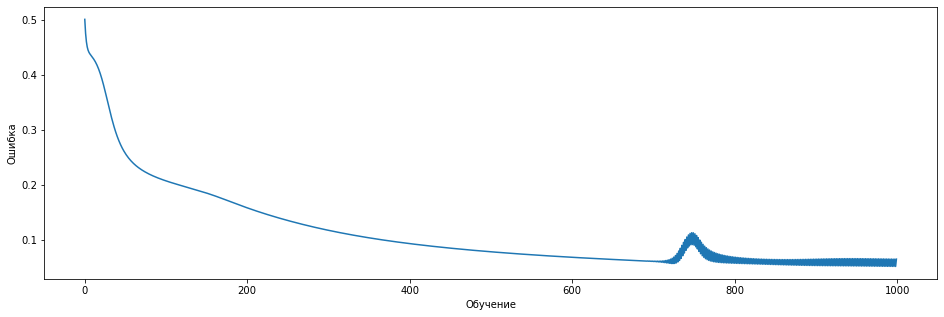

In [11]:
plt.figure(figsize = (16,5))
plt.plot(err)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() # расскоментируйте, чтобы посмотреть 

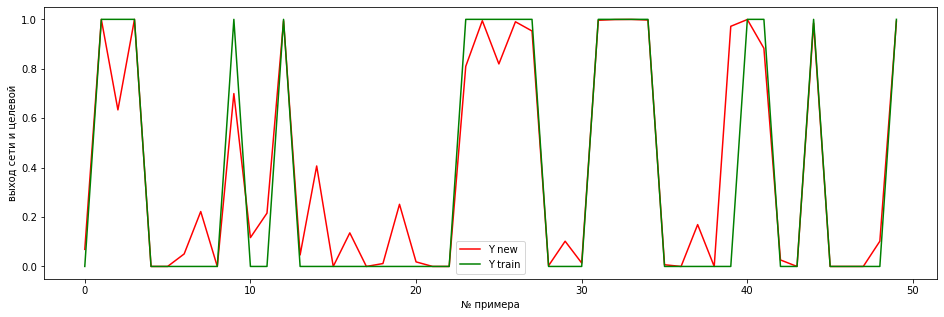

Аккуратность нейронной сети на тесте 92.61%


In [12]:
# прямое распространение(feed forward)
layer0_t = X_test
layer1_t = sigmoid(np.dot(layer0_t, w0))
layer2_t = sigmoid(np.dot(layer1_t, w1))
layer2_error_t = y_test - layer2_t
    
    
N = 50
plt.figure(figsize = (16,5))
plt.plot(layer2_t[:N,1], 'r',label = 'Y new')
plt.plot(y_test[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть

# метрика модели
error_t = np.mean(np.abs(layer2_error_t))
accuracy_t = (1 - error_t) * 100
print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

#### params grid for 1-layer model

In [13]:
params_grid = {
    'nnumbs': [2, 3, 4, 5, 6],
    'iterations': [100, 300, 500, 1000, 1500, 3000, 5000],   
}

In [14]:
errors_history_params = []
iters_history_params = []
for n_numb in params_grid['nnumbs']:
    errors_by_nnumb = []
    iters_by_nnumb = []
    
    for iters in params_grid['iterations']:
        err, best_iter, acc, w0, w1 = train_nn_l1(X_train, y_train, n_numb, iters)
        errors_by_nnumb.append(np.min(err))
        iters_by_nnumb.append(best_iter)
    errors_history_params.append(errors_by_nnumb)
    iters_history_params.append(iters_by_nnumb)

In [15]:
pd.DataFrame(iters_history_params, index = params_grid['nnumbs'], columns = params_grid['iterations'])

,100,300,500,1000,1500,3000,5000
2,99,299,121,818,1499,830,1006
3,99,299,499,379,1499,2999,4999
4,99,299,464,999,1499,2999,4999
5,99,299,499,999,1499,2999,3672
6,99,299,433,999,1499,2999,4757


In [16]:
scores_history = pd.DataFrame(errors_history_params, index = params_grid['nnumbs'], columns = params_grid['iterations'])

Text(51.0, 0.5, '$neuron numbers$')

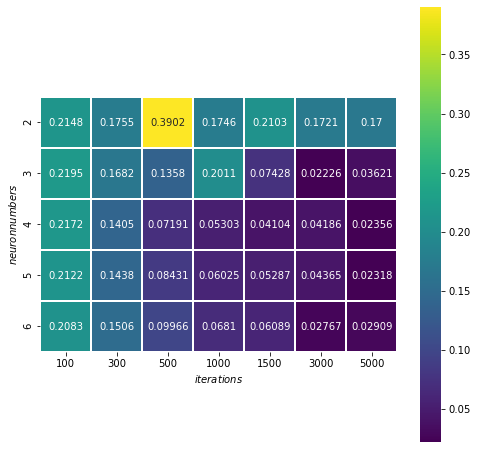

In [17]:
fig, axes = plt.subplots(1, 1, figsize = (8, 8))
sns.heatmap(scores_history, cmap = 'viridis', annot = True, fmt = '.4g', linewidths = 1, square = True, ax = axes)
axes.set_xlabel('$iterations$')
axes.set_ylabel('$neuron numbers$')

С одновременным ростом количества нейронов в слое и количеством итераций ошибка снижается. При фиксировании одного из параметров и изменении другого прямой связи между ростом параметра и падением ошибки может и не быть

### 2 слоя

In [18]:
def train_nn_l2(data, target, n_numb, iters):
    # определим число нейронов скрытого слоя
    neuron_numb = n_numb
    
    # присваивание случайных весов
    w0 = 2*np.random.random((4, neuron_numb)) - 1
    w1 = 2*np.random.random((neuron_numb, neuron_numb))
    w2 = 2*np.random.random((neuron_numb, 3)) - 1

    # скорость обучения (learning rate)
    n = 0.1

    # массив для ошибок, чтобы потом построить график
    errors = []

    # процесс обучения
    for i in range(iters):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))
        layer3 = sigmoid(np.dot(layer2, w2))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer3_error = y_train - layer3 # производная функции потерь = производная квадратичных потерь 
        layer3_delta = layer3_error * sigmoid_deriv(layer3)

        layer2_error = layer3_delta.dot(w2.T)
        layer2_delta = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w2 += layer2.T.dot(layer3_delta) * n
        w1 += layer1.T.dot(layer2_delta) * n
        w0 += layer0.T.dot(layer1_delta) * n
        
        # метрика модели
        error = np.mean(np.abs(layer3_error))
        errors.append(error)
    accuracy = (1 - min(errors)) * 100
    
        
    return errors, errors.index(np.min(errors)), accuracy, w0, w1, w2

In [19]:
def run_nn_l2(inputs, w0, w1, w2):
    inputs = inputs.astype(float)
    l1 = sigmoid(np.dot(inputs, w0))
    l2 = sigmoid(np.dot(l1, w1))
    l3 = sigmoid(np.dot(l2, w2))
    outputs = from_one_hot(np.around(l3))
    
    return outputs

In [20]:
err, best_iter, acc, w0, w1, w2 = train_nn_l2(X_train, y_train, 4, 1000)

In [21]:
preds = run_nn_l2(X_test, w0, w1, w2)
preds

array([2., 1., 2., 1., 0., 0., 2., 2., 0., 2., 2., 2., 1., 2., 2., 0., 2.,
       0., 2., 2., 2., 0., 0., 2., 1., 2., 1., 1., 2., 2., 2., 1., 1., 1.,
       1., 2., 0., 2., 0., 1., 1., 2., 2., 0., 1., 2., 0., 0., 2., 1.])

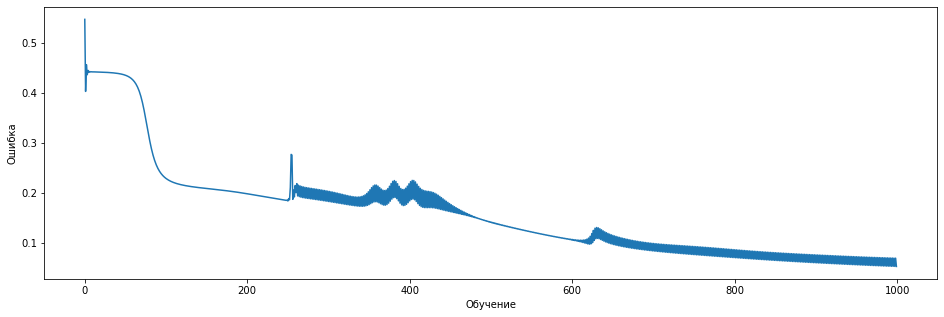

In [22]:
plt.figure(figsize = (16,5))
plt.plot(err)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() # расскоментируйте, чтобы посмотреть 

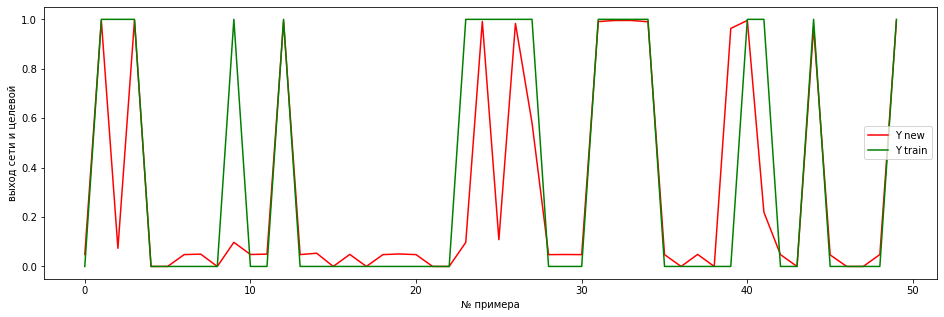

Аккуратность нейронной сети на тесте 88.29%


In [23]:
# прямое распространение(feed forward)
layer0_t = X_test
layer1_t = sigmoid(np.dot(layer0_t, w0))
layer2_t = sigmoid(np.dot(layer1_t, w1))
layer3_t = sigmoid(np.dot(layer2_t, w2))
layer3_error_t = y_test - layer3_t
    
    
N = 50
plt.figure(figsize = (16,5))
plt.plot(layer3_t[:N,1], 'r',label = 'Y new')
plt.plot(y_test[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть

# метрика модели
error_t = np.mean(np.abs(layer3_error_t))
accuracy_t = (1 - error_t) * 100
print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

#### params grid for 2-layer model

In [24]:
errors_history_params = []
iters_history_params = []
for n_numb in params_grid['nnumbs']:
    errors_by_nnumb = []
    iters_by_nnumb = []
    
    for iters in params_grid['iterations']:
        err, best_iter, acc, w0, w1 = train_nn_l1(X_train, y_train, n_numb, iters)
        errors_by_nnumb.append(np.min(err))
        iters_by_nnumb.append(best_iter)
    errors_history_params.append(errors_by_nnumb)
    iters_history_params.append(iters_by_nnumb)

In [25]:
pd.DataFrame(iters_history_params, index = params_grid['nnumbs'], columns = params_grid['iterations'])

,100,300,500,1000,1500,3000,5000
2,99,299,499,899,762,2999,4999
3,99,244,499,999,1059,2346,4999
4,99,299,499,999,1499,2999,4999
5,99,261,499,999,1499,2998,4999
6,99,299,499,999,1499,2999,4999


In [26]:
scores_history2 = pd.DataFrame(errors_history_params, index = params_grid['nnumbs'], columns = params_grid['iterations'])

Text(609.9818181818181, 0.5, '$neuron numbers$')

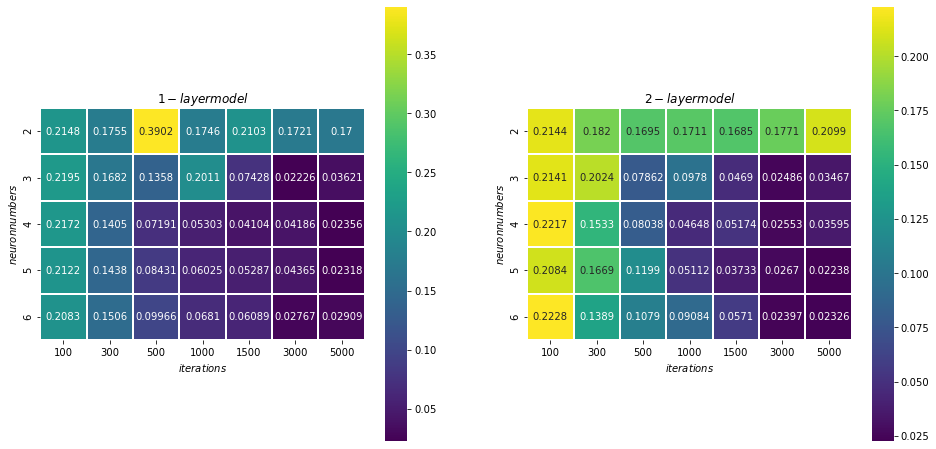

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))
sns.heatmap(scores_history, cmap = 'viridis', annot = True, fmt = '.4g', linewidths = 1, square = True, ax = axes[0])
sns.heatmap(scores_history2, cmap = 'viridis', annot = True, fmt = '.4g', linewidths = 1, square = True, ax = axes[1])
axes[0].set_title('$1-layer model$')
axes[0].set_xlabel('$iterations$')
axes[0].set_ylabel('$neuron numbers$')
axes[1].set_title('$2-layer model$')
axes[1].set_xlabel('$iterations$')
axes[1].set_ylabel('$neuron numbers$')

Аналогично однослойной модели с одновременным ростом количества нейронов в слое и количеством итераций ошибка снижается. При фиксировании одного из параметров и изменении другого прямой связи между ростом параметра и падением ошибки так же может и не быть

Однозначного вывода о том, что модель с двумя слоями в данном случае работает лучше однослойной, сделать нельзя. Также стоит отметить, что не всегда рост количества итераций ведет к минимизации ошибки - после определенного значения ошибка может начать расти